<a href="https://colab.research.google.com/github/elmahygurl/NLP_sst_Classification/blob/main/NLP_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting dataset

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.7 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset, Dataset


In [4]:
sst_dataset = load_dataset('sst')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for sst contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sst
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

In [5]:
print(sst_dataset['train'][500])
print(f"Number of training examples: {len(sst_dataset['train'])}")
print(f"Number of validation examples: {len(sst_dataset['validation'])}")
print(f"Number of test examples: {len(sst_dataset['test'])}")

{'sentence': 'This story still seems timely and important .', 'label': 0.6944400072097778, 'tokens': 'This|story|still|seems|timely|and|important|.', 'tree': '14|14|13|11|9|9|10|12|10|11|12|13|15|15|0'}
Number of training examples: 8544
Number of validation examples: 1101
Number of test examples: 2210


# Preprocessing

Removing the 'tree' column and adjusting the labels to accomodate the 5 classes we want to classify to where:
From 0 to 0.2 (0.2 included) will be class 0 “very negative”.

From 0.2 to 0.4 (0.4 included) will be class 1 “negative”.

From 0.4 to 0.6 (0.6 included) will be class 2 “neutral”.

From 0.6 to 0.8 (0.8 included) will be class 3 “positive”.

From 0.8 to 1.0 (1.0 included) will be class 4 “very positive”.

In [9]:
#converting splits to Pandas DataFrame for manipulation
import pandas as pd
train_df = pd.DataFrame(sst_dataset['train'])
test_df = pd.DataFrame(sst_dataset['test'])
val_df = pd.DataFrame(sst_dataset['validation'])

#function to map float labels to our desired categorical classes
def map_labels_to_categories(label):
    if 0.0 <= label <= 0.2:
        return 0  # very negative
    elif 0.2 < label <= 0.4:
        return 1  # negative
    elif 0.4 < label <= 0.6:
        return 2  # neutral
    elif 0.6 < label <= 0.8:
        return 3  # positive
    elif 0.8 < label <= 1.0:
        return 4  # very positive

#mapping function to create a new column with mapped labels
train_df['mapped_label'] = train_df['label'].apply(map_labels_to_categories)
test_df['mapped_label'] = test_df['label'].apply(map_labels_to_categories)
val_df['mapped_label'] = val_df['label'].apply(map_labels_to_categories)

#dropping the original label column
train_df = train_df.drop('label', axis=1)
test_df = test_df.drop('label', axis=1)
val_df = val_df.drop('label', axis=1)

train_df = train_df.drop(columns=['tree']) #dropping 'tree' column
test_df = test_df.drop(columns=['tree'])
val_df = val_df.drop(columns=['tree'])


#convert the DataFrame back to the datasets format
sst_dataset['train'] = Dataset.from_pandas(train_df)
sst_dataset['test'] = Dataset.from_pandas(test_df)
sst_dataset['validation'] = Dataset.from_pandas(val_df)

#display the updated dataset
print(sst_dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'tokens', 'mapped_label'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['sentence', 'tokens', 'mapped_label'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['sentence', 'tokens', 'mapped_label'],
        num_rows: 2210
    })
})


In [10]:
#analyzing the distribution of labels
train_label_distribution = train_df['mapped_label'].value_counts().sort_index()
test_label_distribution = test_df['mapped_label'].value_counts().sort_index()
val_label_distribution = val_df['mapped_label'].value_counts().sort_index()

print("Training Split Label Distribution:")
print(train_label_distribution)

print("\nTest Split Label Distribution:")
print(test_label_distribution)

print("\nValidation Split Label Distribution:")
print(val_label_distribution)


Training Split Label Distribution:
0    1092
1    2218
2    1624
3    2322
4    1288
Name: mapped_label, dtype: int64

Test Split Label Distribution:
0    279
1    633
2    389
3    510
4    399
Name: mapped_label, dtype: int64

Validation Split Label Distribution:
0    139
1    289
2    229
3    279
4    165
Name: mapped_label, dtype: int64


### Visualisation for us

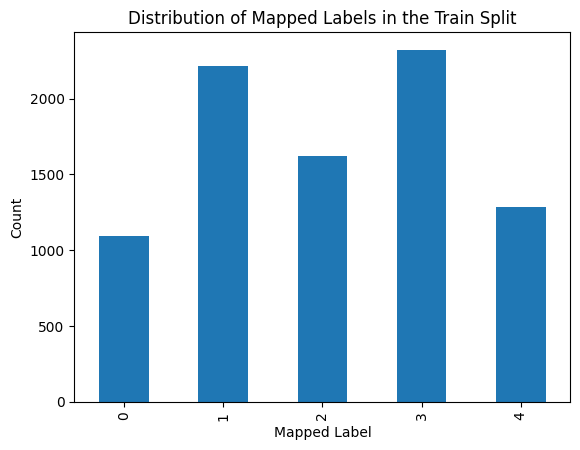

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
train_df = pd.DataFrame(sst_dataset['train']) #convert the 'train' split to a Pandas DataFrame

# Plot the distribution of mapped labels in the 'train' split
train_df['mapped_label'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Mapped Labels in the Train Split')
plt.xlabel('Mapped Label')
plt.ylabel('Count')
plt.show()

In [12]:
# Print the first few rows of the 'train' split to see the transformed data
print(train_df.head())

# Check the unique values in the 'mapped_label' column of the 'train' split to ensure correct mapping
print(train_df['mapped_label'].unique())

# Check for missing values in the 'mapped_label' column of the 'train' split
print(train_df['mapped_label'].isnull().sum())
# # Print the first few rows of the 'train' split to see the transformed data
# print(sst_dataset['train'].head())

# # Check the unique values in the 'mapped_label' column of the 'train' split to ensure correct mapping
# print(sst_dataset['train']['mapped_label'].unique())

# # Check for missing values in the 'mapped_label' column of the 'train' split
# print(sst_dataset['train']['mapped_label'].isnull().sum())

                                            sentence  \
0  The Rock is destined to be the 21st Century 's...   
1  The gorgeously elaborate continuation of `` Th...   
2  Singer\/composer Bryan Adams contributes a sle...   
3  You 'd think by now America would have had eno...   
4               Yet the act is still charming here .   

                                              tokens  mapped_label  
0  The|Rock|is|destined|to|be|the|21st|Century|'s...             3  
1  The|gorgeously|elaborate|continuation|of|``|Th...             4  
2  Singer\/composer|Bryan|Adams|contributes|a|sle...             3  
3  You|'d|think|by|now|America|would|have|had|eno...             2  
4               Yet|the|act|is|still|charming|here|.             3  
[3 4 2 1 0]
0


## Naive Bayes


In [ ]:
import numpy as np

def preprocess_data(data):
    # Tokenize the text
    tokens = [doc.split() for doc in data]

    # Create a vocabulary
    vocab = set(word for doc in tokens for word in doc)

    # Convert text to bag-of-words representation
    bow_representation = []
    for doc in tokens:
        bow = np.zeros(len(vocab))
        for word in doc:
            if word in vocab:
                bow[vocab.index(word)] += 1
        bow_representation.append(bow)

    return bow_representation, vocab

In [ ]:
def train_naive_bayes(data, labels, num_classes):
    # Calculate the number of documents and the vocabulary size
    num_docs = len(data)
    vocab = set(word for doc in data for word in doc)

    # Initialize the log prior and log likelihood matrices
    log_prior = np.zeros(num_classes)
    log_likelihood = np.zeros((len(vocab), num_classes))

    # Calculate the log prior probabilities
    for c in range(num_classes):
        num_c = sum(1 for label in labels if label == c)
        log_prior[c] = np.log(num_c / num_docs)

    # Calculate the log likelihood probabilities
    for c in range(num_classes):
        class_docs = [doc for doc, label in zip(data, labels) if label == c]
        for i, word in enumerate(vocab):
            count = sum(doc[i] for doc in class_docs if i < len(doc))
            log_likelihood[i, c] = np.log((count + 1) / (sum(doc[i] for doc in class_docs) + len(vocab)))

    return log_prior, log_likelihood, vocab

In [ ]:
def test_naive_bayes(test_doc, log_prior, log_likelihood, num_classes, vocab):
    # Convert the test document to a bag-of-words representation
    test_bow = np.zeros(len(vocab))
    for i, word in enumerate(test_doc):
        if word in vocab:
            test_bow[vocab.index(word)] += 1

    # Calculate the log probability for each class
    log_prob = np.zeros(num_classes)
    for c in range(num_classes):
        log_prob[c] = log_prior[c] + np.sum(test_bow * log_likelihood[:, c])

    # Return the class with the highest log probability
    return np.argmax(log_prob)

# Logistic regression

In [13]:
import numpy as np

def features_extract(data):
    # Initialize a set to store sentence and bigrams pairs
    sentence_bigrams_set = set()
    unique_bigrams = set()

    # Extract relevant information from the dataset
    for i in range(len(data)):
        # Initialize a list to store unique word bi-grams
        sentence = data['sentence'][i]
        tokens = data['tokens'][i].split('|')

        # Build bigrams
        bigrams = [f"{tokens[j]} {tokens[j + 1]}" for j in range(len(tokens) - 1)]

        # Add the pair to the set
        sentence_bigrams_set.add((sentence, tuple(bigrams)))
        unique_bigrams.update(set(bigrams))

    # Create a list of unique words
    unique_words = sorted(list(set(word for sentence in data['tokens'] for word in sentence.split('|'))))

    # Create a binary matrix to store bigram existence
    bigram_matrix = np.zeros((len(unique_words), len(unique_words)), dtype=int)

    # Populate the matrix
    for i, word1 in enumerate(unique_words):
        for j, word2 in enumerate(unique_words):
            if (word1, word2) in unique_bigrams:
                bigram_matrix[i, j] = 1

    return bigram_matrix, unique_words

# Example usage with a dummy dataset
sst_dataset = {
    'tokens': ["apple|orange|banana", "orange|grape|kiwi", "kiwi|banana|apple"],
    'sentence': ["This is the first sentence.", "Another sentence here.", "And one more sentence."]
}

train_dataset = sst_dataset  # Replace with your actual dataset
binary_bigram_matrix, unique_words = features_extract(train_dataset)

# Print the resulting matrix
print("Binary Bigram Matrix:")
print(binary_bigram_matrix)


Binary Bigram Matrix:
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
